<center>
    
    Modeling Slip-Stick Motion with the LuGre Friction Model
    
    Author: Daniel Coble
    
    Status: Finished
</center>

I am following [this](https://hal.archives-ouvertes.fr/hal-00394988/document) explanation of the LuGre friction model and recreating the model shown in Figure 4.

Defining constants of the LuGre model and of the system.

In [43]:
m = 1 # mass of the system
k = 2 # spring constant
delta_t = .00001 # division of time

alpha = 1
sigma_0 = 2900 # LuGre representation of stiffness
sigma_1 = 107 # LuGre representation of micro damping
sigma_2 = 0 # memoryless velocity dependence factor
f = lambda v: sigma_2*v # general memoryless velocity dependence, taken to be linear with velocity.
F_c =  2.94 # kinetic friction force
F_s = 5.88 # static friction force
v_s = 0.1 # rate parameter of g

In [44]:
from math import exp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

g = lambda v: F_c + (F_s - F_c)*exp(-abs(v/v_s)**alpha)

# provide new z and v values.
def update_model_state(F_act, z, v, x):
    zdot = v - sigma_0*abs(v)/g(v)*z
    F = sigma_0*z + sigma_1*zdot + f(v) # friction force
    F_tot = F_act - F
    vdot = F_tot/m
    z += zdot*delta_t
    v += vdot*delta_t
    x += v*delta_t
    return z, v, x, F

Modelling a weight being pulled by a moving spring.

In [45]:
v_p = 2
time = 20
timesteps = int(time/delta_t)
dist = timesteps*delta_t*v_p # distance travelled by the spring
delta_s = dist/timesteps
z = np.zeros((timesteps))
v = np.zeros((timesteps))
x = np.zeros((timesteps))
F = np.zeros((timesteps))
t = np.linspace(0, timesteps*delta_t, timesteps)
x_s = np.zeros((timesteps)) # fills to np.linspace(0, dist, timesteps)
z_t = 0
v_t = 0
x_t = 0
x_st = 0
for i in range(1, timesteps):
    F_act = k*(x_st - x_t)
    z_t, v_t, x_t, F_t = update_model_state(F_act, z_t, v_t, x_t)
    x_st += delta_s
    z[i] = z_t
    v[i] = v_t
    x[i] = x_t
    x_s[i] = x_st
    F[i] = F_t
l = x_s - x

Text(0, 0.5, 'F')

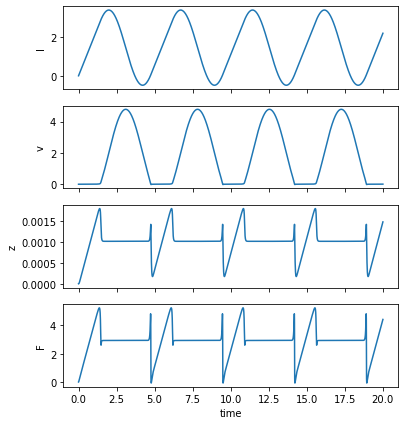

In [46]:
fig, ax = plt.subplots(4,1, sharex=True, figsize=(6,7))
plt.xlabel("time")
ax[0].plot(t, l)
ax[0].set_ylabel("l")
ax[1].plot(t, v)
ax[1].set_ylabel("v")
ax[2].plot(t, z)
ax[2].set_ylabel("z")
ax[3].plot(t, F)
ax[3].set_ylabel("F")

In [47]:
# animation
plt.rcParams["animation.html"] = "jshtml" # necessary only for jupyter notebooks
fig, ax = plt.subplots(1,1, sharex=True, figsize=(8,2))
# plt.xlim((0, v_p*time))
plt.yticks([])
plt.ylim((0,2))
rate=40
frames = 10*rate

x_plot = x[t<9.45]
x_plot = x_plot[:x_plot.size//frames*frames].reshape(frames, -1)[:,0]
x_s_plot = x_s[t<9.45]
x_s_plot = x_s_plot[:x_s_plot.size//frames*frames].reshape(frames, -1)[:,0]

l, = ax.plot([],[],c='k')
b, = ax.plot([],[], marker='s',c='k',ms=50)
p, = ax.plot([], [], marker='o',c='k',ms=12)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])

def animate(i):
    l.set_data([x_plot[i], x_s_plot[i]], [.5, .5])
    b.set_data([x_plot[i]], [.5])
    p.set_data([x_s_plot[i]], [.5])
    ax.set_xlim((x_s_plot[i]-5, x_s_plot[i]+1.5))

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=frames, interval=1/60*1000)
ani.save("stribeck-animation.gif", writer='ffmpeg', fps=60)
plt.close()
ani

Creating the hysteresis curve with forced displacement. For all hysterisis plots that I've seen, the shape implies that $\sigma_1=0$ or is close to zero.

In [48]:
m = 1 # mass of the system
delta_t = .00001 # division of time

alpha = 1
sigma_0 = 500 # LuGre representation of stiffness
sigma_1 = 0 # LuGre representation of micro damping.
sigma_2 = 0 # memoryless velocity dependence factor
f = lambda v: sigma_2*v # general memoryless velocity dependence, taken to be linear with velocity.
F_c =  2.94 # kinetic friction force
F_s = 5.88 # static friction force
v_s = 0.1 # rate parameter of g

g = lambda v: F_c + (F_s - F_c)*exp(-abs(v/v_s)**alpha)

# provide new z and F values.
def update_model_state(z, v):
    zdot = v - sigma_0*abs(v)/g(v)*z
    F = sigma_0*z + sigma_1*zdot + f(v) # friction force
    z += zdot*delta_t
    return z, F

In [49]:
time = 20
timesteps = int(time/delta_t)
freq = 6
disp = .1
z = np.zeros((timesteps))
x = disp*np.cos(freq*np.pi*np.linspace(0,time, timesteps))
v = -disp*freq*np.pi*np.sin(freq*np.pi*np.linspace(0,time, timesteps))
F = np.zeros((timesteps))
z_t = 0
v_t = 0
x_t = 0
x_st = 0
for i in range(1, timesteps):
    z_t, F_t = update_model_state(z_t, v[i])
    z[i] = z_t
    F[i] = F_t

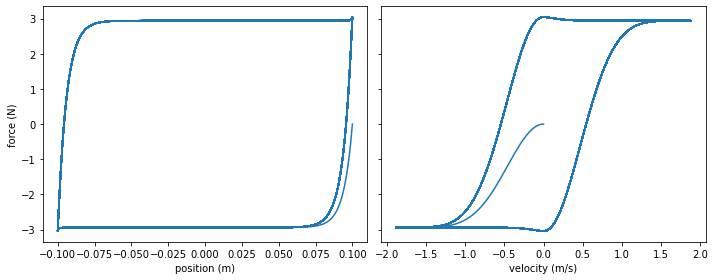

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

ax1.plot(x, F)
ax1.set(xlabel="position (m)", ylabel="force (N)")

ax2.plot(v, F)
ax2.set(xlabel="velocity (m/s)")
plt.tight_layout()